In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json

df = pd.read_csv('../CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])


In [2]:

target = 'Churn'
all_features = [
    'gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges'
]
reduced_features = [f for f in all_features if f not in ['TotalCharges','gender','PhoneService']]


In [3]:

X = df[all_features]
y = df[target].map({'Yes': 1, 'No': 0})
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_red = X_train_full[reduced_features]
X_test_red = X_test_full[reduced_features]


In [4]:
# 4. Preprocessing 
# Ordinal encoding for 'Contract'
ordinal_enc = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])

cat_full = [col for col in all_features if df[col].dtype == 'object' and col != 'Contract']
num_full = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_red = [col for col in reduced_features if df[col].dtype == 'object' and col != 'Contract']
num_red = ['tenure', 'MonthlyCharges']


In [5]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


preprocessor_full = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]),["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_full),
    ("scale", StandardScaler(), num_full),
])

preprocessor_red = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]), ["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_red),
    ("scale",   StandardScaler(), num_red),
])


In [6]:

pipe_full = Pipeline([
    ('pre', preprocessor_full),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_red = Pipeline([
    ('pre', preprocessor_red),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [7]:

pipe_full.fit(X_train_full, y_train)
pipe_red.fit(X_train_red, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('ord_contract',
                                                  OrdinalEncoder(categories=[['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']]),
                                                  ['Contract']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Partner', 'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('scale', StandardScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [8]:

# 7. Evaluate
results = {}
for name, pipe, X_test in [
    ('full', pipe_full, X_test_full),
    ('reduced', pipe_red, X_test_red)
]:
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred).tolist()
    results[name] = {'classification_report': report, 'confusion_matrix': cm}

    print(f"\n=== {name.upper()} MODEL ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(cm)



=== FULL MODEL ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Confusion Matrix:
[[923, 110], [192, 182]]

=== REDUCED MODEL ===
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.60      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

Confusion Matrix:
[[910, 123], [187, 187]]


In [9]:

# 8. Save artifacts
joblib.dump(pipe_full, 'rf_telco_full_pipeline.pkl')
joblib.dump(pipe_red, 'rf_telco_reduced_pipeline.pkl')

joblib.dump((X_train_full, X_test_full, y_train, y_test), 'telco_train_test_full.pkl')
joblib.dump((X_train_red, X_test_red), 'telco_train_test_reduced.pkl')

with open('telco_rf_results.json', 'w') as f:
    json.dump(results, f)

print("\nModels, data splits, and evaluation results saved successfully.")



Models, data splits, and evaluation results saved successfully.


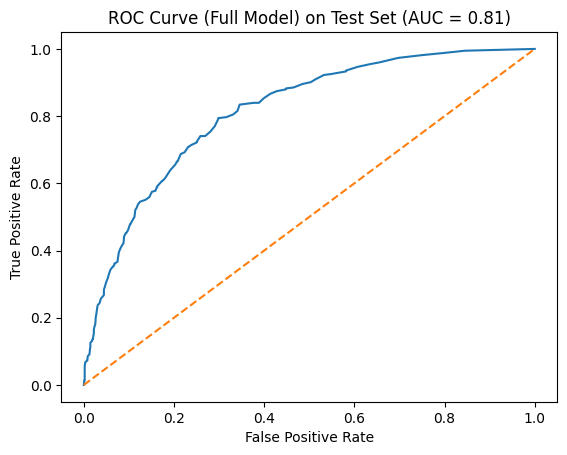

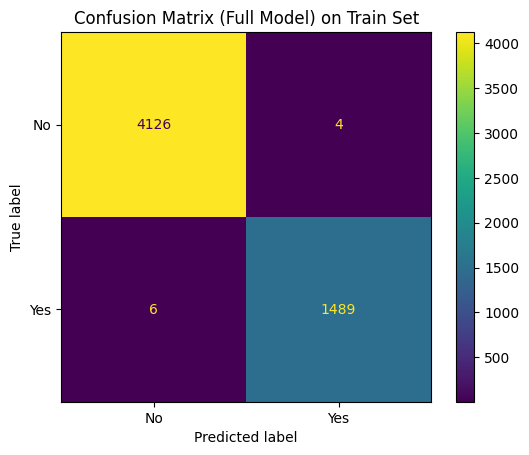

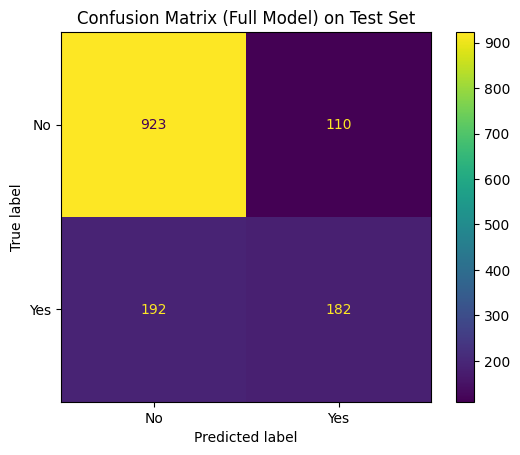

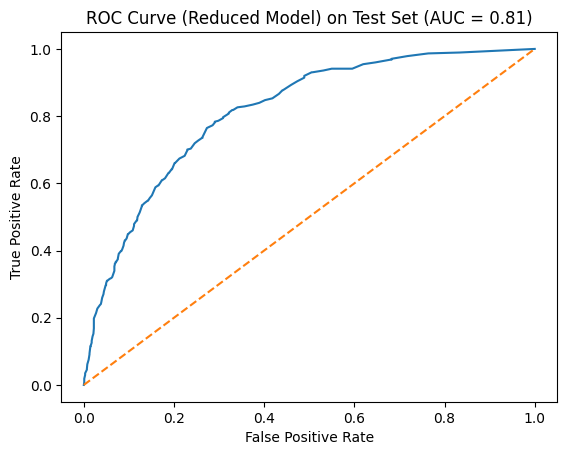

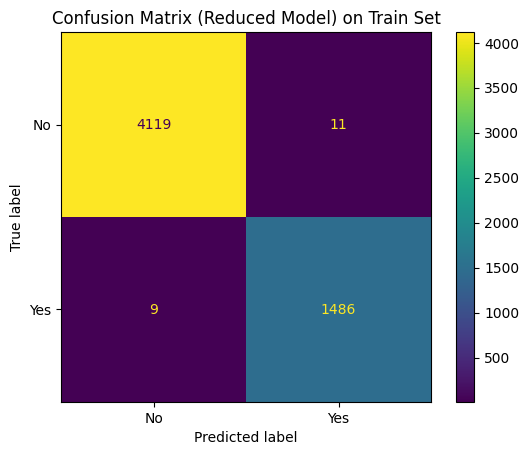

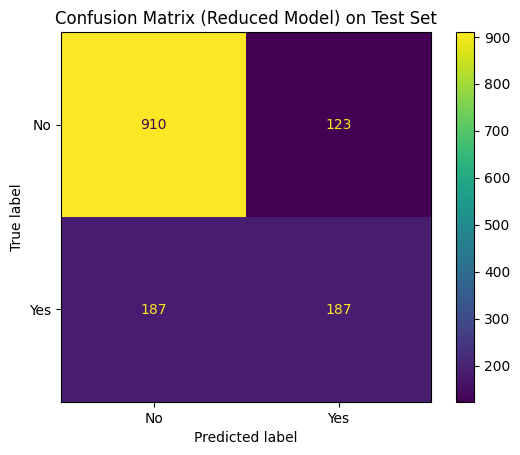

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay


models = [
    ('Full Model', pipe_full, X_train_full, X_test_full),
    ('Reduced Model', pipe_red, X_train_red, X_test_red),
]

for name, pipe, X_tr, X_te in models:
    # ROC Curve on Test Set
    y_proba = pipe.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'ROC Curve ({name}) on Test Set (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    # Confusion Matrices 
    for split_name, X_split, y_split in [('Train', X_tr, y_train), ('Test', X_te, y_test)]:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_split,
            pipe.predict(X_split),
            display_labels=['No', 'Yes']
        )
        plt.title(f'Confusion Matrix ({name}) on {split_name} Set')
        plt.show()


In [ ]:
import pandas as pd

for name, pipe in [('Full Model', pipe_full), ('Reduced Model', pipe_red)]:
    preprocessor = pipe.named_steps['pre']
    feature_names = preprocessor.get_feature_names_out()
    
    rf = pipe.named_steps['rf']
    importances = rf.feature_importances_
    
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    print(f"\nTop 10 Important Predictors for {name}:")
    print(feat_imp.head(10))



Top 10 Important Predictors for Full Model:
scale__TotalCharges                       0.198362
scale__MonthlyCharges                     0.180495
scale__tenure                             0.165643
ord_contract__Contract                    0.086181
onehot__InternetService_Fiber optic       0.041886
onehot__PaymentMethod_Electronic check    0.034450
onehot__gender_Male                       0.027974
onehot__PaperlessBilling_Yes              0.027065
onehot__OnlineSecurity_Yes                0.024639
onehot__Partner_Yes                       0.022979
dtype: float64

Top 10 Important Predictors for Reduced Model:
scale__MonthlyCharges                     0.270924
scale__tenure                             0.249101
ord_contract__Contract                    0.099344
onehot__InternetService_Fiber optic       0.041974
onehot__PaymentMethod_Electronic check    0.037948
onehot__PaperlessBilling_Yes              0.029700
onehot__OnlineSecurity_Yes                0.028671
onehot__Partner_Yes      

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from collections import defaultdict

pipelines = {
    "full":    (pipe_full,   X[all_features]),
    "reduced": (pipe_red,    X[reduced_features])
}
y = df[target].map({'Yes':1,'No':0})

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = {name: defaultdict(list) for name in pipelines}
cv_imps    = {name: []            for name in pipelines}

for name, (pipe, X_data) in pipelines.items():
    for train_idx, test_idx in skf.split(X_data, y):
        X_tr, X_te = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_tr, y_tr)

        y_proba = pipe.predict_proba(X_te)[:,1]
        y_pred  = pipe.predict(X_te)
        cv_metrics[name]['auc'].append(roc_auc_score(y_te, y_proba))
        cv_metrics[name]['acc'].append(accuracy_score(y_te, y_pred))

        feat_names = pipe.named_steps['pre'].get_feature_names_out()
        imps       = pipe.named_steps['rf'].feature_importances_
        cv_imps[name].append(pd.Series(imps, index=feat_names))

for name in pipelines:
    print(f"\n== {name.upper()} MODEL ==")

    for metric, vals in cv_metrics[name].items():
        mean, std = np.mean(vals), np.std(vals)
        print(f"{metric.upper():>4}: {mean:.3f} ± {std:.3f}")

    metrics_df = pd.DataFrame(cv_metrics[name])
    metrics_df.index = [f"Fold {i+1}" for i in range(skf.n_splits)]
    print(f"\n-- Per‐Fold Metrics --")
    print(metrics_df)

    imp_df = pd.concat(cv_imps[name], axis=1)
    imp_df.columns = [f"Fold {i+1}" for i in range(skf.n_splits)]
    mean_imp = imp_df.mean(axis=1).sort_values(ascending=False)
    top10    = mean_imp.head(10).index

    print(f"\n-- Feature Importances by Fold (Top 10 features) --")
    print(imp_df.loc[top10])




== FULL MODEL ==
 AUC: 0.826 ± 0.005
 ACC: 0.792 ± 0.005

-- Per‐Fold Metrics --
             auc       acc
Fold 1  0.829224  0.794598
Fold 2  0.833326  0.795309
Fold 3  0.822951  0.781650
Fold 4  0.828172  0.791607
Fold 5  0.817452  0.795875

-- Feature Importances by Fold (Top 10 features) --
                                          Fold 1    Fold 2    Fold 3  \
scale__TotalCharges                     0.197961  0.199445  0.199204   
scale__MonthlyCharges                   0.183184  0.180284  0.179324   
scale__tenure                           0.168147  0.168015  0.168162   
ord_contract__Contract                  0.081995  0.076544  0.081666   
onehot__InternetService_Fiber optic     0.044079  0.045466  0.046580   
onehot__PaymentMethod_Electronic check  0.034251  0.032656  0.031429   
onehot__gender_Male                     0.028740  0.028681  0.028577   
onehot__PaperlessBilling_Yes            0.025964  0.027232  0.027364   
onehot__OnlineSecurity_Yes              0.023008  0.022

In [15]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.7/150.0 MB 29.3 MB/s eta 0:00:05
   --- ------------------------------------ 14.2/150.0 MB 42.2 MB/s eta 0:00:04
   ------- -------------------------------- 27.3/150.0 MB 55.4 MB/s eta 0:00:03
   ------------- -------------------------- 49.8/150.0 MB 66.4 MB/s eta 0:00:02
   ------------------ --------------------- 68.9/150.0 MB 71.4 MB/s eta 0:00:02
   ----------------------- ---------------- 87.0/150.0 MB 74.5 MB/s eta 0:00:01
   -------------------------- ------------ 103.3/150.0 MB 75.4 MB/s eta 0:00:01
   ------------------------------- ------- 122.2/150.0 MB 77.2 MB/s eta 0:00:01
   ------------------------------------ -- 141.3/150.0 MB 78.5 MB/s eta 0:00:01
   --------------------------------------  149.9/150.0 MB 79.1 MB/s eta 0:00:01
   --------------------------------------- 150.0/150.0 MB 71.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use up


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:31] WARNING: C:\actio

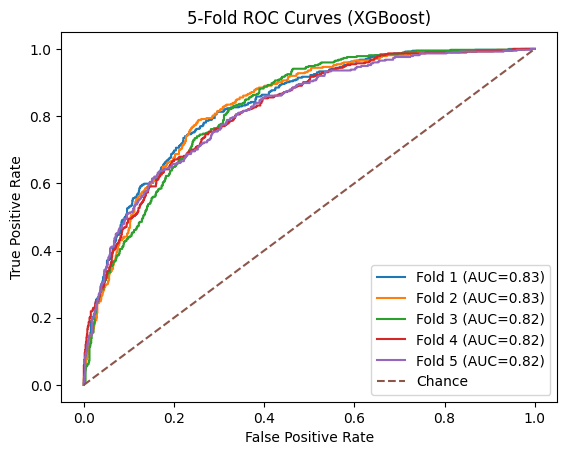

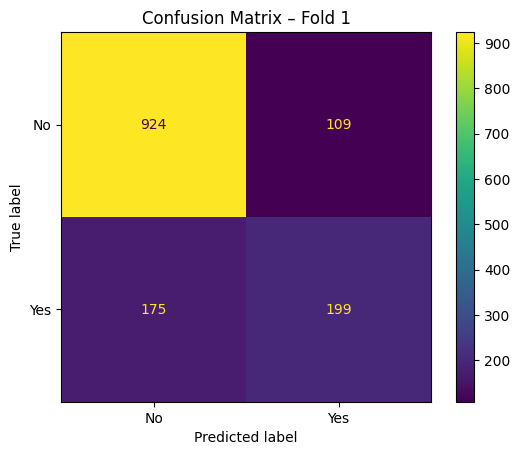

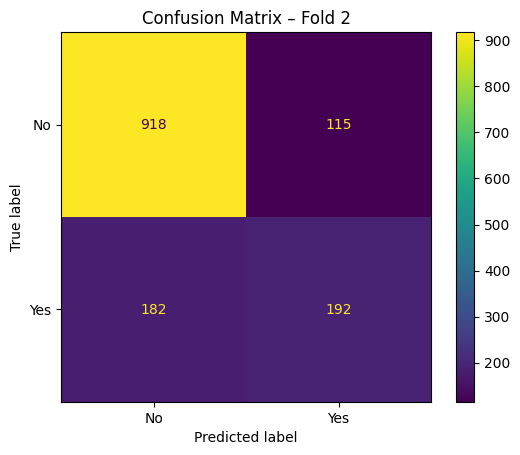

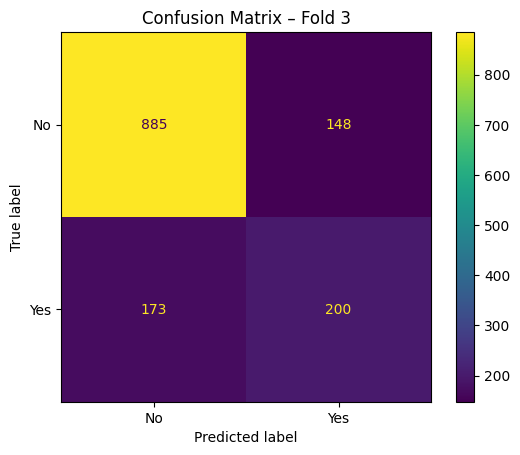

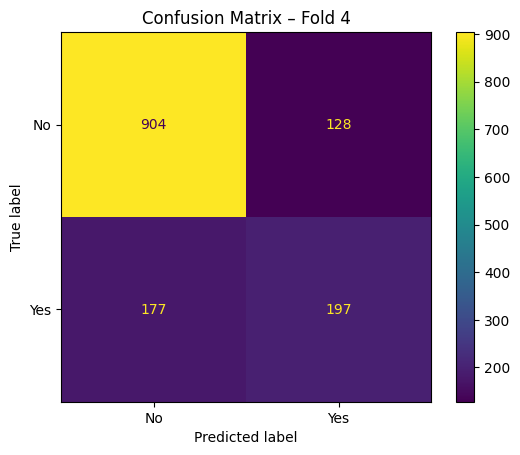

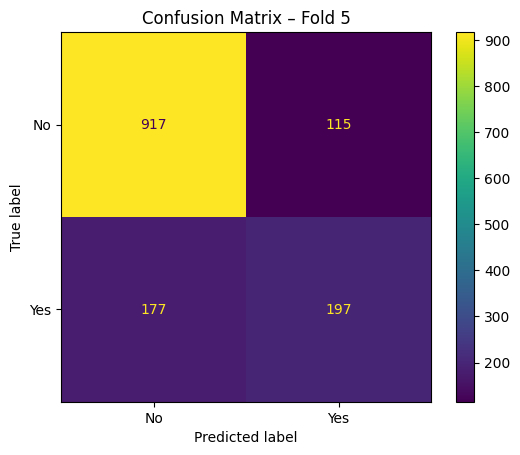

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

pipe_xgb = Pipeline([
    ('pre', preprocessor_full),  
    ('xgb', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

X_full = X[all_features]
y_bin  = df[target].map({'Yes': 1, 'No': 0})

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_list = []
roc_curves   = {}
conf_matrices = {}

for fold, (tr_idx, te_idx) in enumerate(skf.split(X_full, y_bin), start=1):
    X_tr, X_te = X_full.iloc[tr_idx], X_full.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    # 
    pipe_xgb.fit(X_tr, y_tr)

    y_proba = pipe_xgb.predict_proba(X_te)[:, 1]
    y_pred  = pipe_xgb.predict(X_te)

    auc   = roc_auc_score(y_te, y_proba)
    acc   = accuracy_score(y_te, y_pred)
    prec  = precision_score(y_te, y_pred)
    rec   = recall_score(y_te, y_pred)
    f1    = f1_score(y_te, y_pred)
    cm    = confusion_matrix(y_te, y_pred)

    # Store metrics
    metrics_list.append({
        'Fold': fold,
        'AUC': auc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_curves[f'Fold {fold}'] = (fpr, tpr)
    conf_matrices[f'Fold {fold}'] = cm

metrics_df = pd.DataFrame(metrics_list).set_index('Fold')
metrics_df.loc['Mean'] = metrics_df.mean()
metrics_df.loc['Std']  = metrics_df.std()

metrics_df.to_csv('xgb_cv_metrics.csv')

pd.to_pickle(conf_matrices, 'xgb_confusion_matrices.pkl')

plt.figure()
for fold, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{fold} (AUC={metrics_df.at[int(fold.split()[1]), "AUC"]:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Chance')
plt.title('5-Fold ROC Curves (XGBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('xgb_roc_curves.png')
plt.show()

for fold, cm in conf_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot()
    plt.title(f'Confusion Matrix – {fold}')
    plt.savefig(f'xgb_confusion_matrix_{fold}.png')
    plt.show()




c:\Users\haris\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:26:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


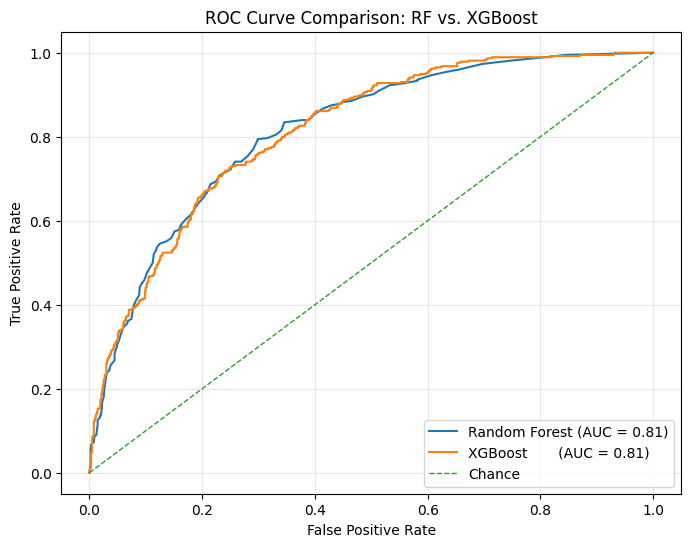

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pipe_full.fit(X_train_full, y_train)
pipe_xgb.fit (X_train_full, y_train)

y_proba_rf  = pipe_full.predict_proba(X_test_full)[:, 1]
y_proba_xgb = pipe_xgb.predict_proba (X_test_full)[:, 1]

fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_proba_rf)
auc_rf  = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf,  tpr_rf,  label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost       (AUC = {auc_xgb:.2f})')
plt.plot([0,1], [0,1], '--', linewidth=1, label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: RF vs. XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
